# Bayesian Neural Networks to Predict Hard Landing with DASHlink Data
Authors: Dr. Yingxiao Kong, Vanderbilt University

Email: yingxiao.kong@vanderbit.edu

## Overview of Research
In this work, we use an open-source dataset - [NASA's DASHlink data](https://c3.ndc.nasa.gov/dashlink/) - to isolate data for landing aircraft that both have hard landing and normal landing occurrences. The objective is to use [this sample data](https://c3.ndc.nasa.gov/dashlink/projects/85/resources/?type=ds) to train a Bayesian Neural Network model to predict touchdown vertical speed for a landing aircraft with the intent to use as a screening for identifying hard landing events before they occur.

This series of Jupyter notebook demonstrations into 3 modules. The presented module is in **bold**:
- Module 1 - Download DASHlink Data
- Module 2 - DASHlink Data Pre-Processing and Feature Selection with Maximum Relevance and Minimum Reduandancy (MRMR)
- **Module 3 - Bayesian Neural Network Model Training**

## Module 3: Bayesian Neural Network Model Training

## Step 3a: Define Training Inputs and Outputs

In [1]:
def train_data(key_list,time_step):

    array_new_data=np.zeros((len(all_new_data),time_step,len(key_list)))

    for i in range(array_new_data.shape[0]):
        for j in range(array_new_data.shape[2]):
            key=key_list[j]
            array_new_data[i,:,j]=all_new_data[i][key][:time_step]

    RNN_x=np.zeros((array_new_data.shape))
    ### RNN_x is normalized array_new_data

    for i in range(RNN_x.shape[1]):
        for j in range(RNN_x.shape[2]):
            RNN_x[:,i,j]=(array_new_data[:,i,j]-np.min(array_new_data[:,i,j]))/(np.max(array_new_data[:,i,j])-np.min(array_new_data[:,i,j])+np.exp(-8))

    RNN_y=np.array(all_td_altr)*0.3048/60

    RNN_y_scale = np.log(RNN_y - min(RNN_y) + 1)
    ### here we also scale down RNN_y_scale to make it eaiser to converge
    delta=np.log(-2-min(RNN_y)+1)
                                                                                
    return RNN_x,RNN_y,RNN_y_scale,delta

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Dropout,LSTM,Activation
from keras.optimizers import Adam
from keras.regularizers import l1,l2
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
import json
import seaborn as sns

In [3]:
all_para=pd.read_csv('all_all_sele_fea_26_spearman.csv')
all_para=all_para.values

In [4]:
### key_list is the one used to do feature sorting and selection
key_list=['DIST','LATP','LONP','MSQT_1','BAL1','TAS','GS','TH','FLAP','GLS','LOC','N1_1','PTCH','ROLL','TRK','AIL_1','RUDD','ELEV_1',\
         'BLAC','CTAC','FPAC','CCPC','CWPC','WS','WD','ALTR']

In [5]:
#### sele_key_list is the one used to generate the RNN_x
sele_key_list=['CCPC','CTAC','PTCH','ELEV_1','BLAC','N1_1','GS','TAS','GLS','WS','ROLL','FPAC','WD','LONP','TH','LATP','DIST','AIL_1','LOC','TRK','BAL1','RUDD','FLAP','ALTR']

In [6]:
RNN_x = np.load('RNN_x_sele.npy')
RNN_y = np.load('RNN_y.npy')
RNN_y_mean = np.mean(RNN_y)
RNN_y_std = np.std(RNN_y)
stand_RNN_y = (RNN_y-RNN_y_mean)/(RNN_y_std)
RNN_y_scale = np.load('RNN_y_scale.npy')
RNN_y_scale_reverse = np.exp(RNN_y_scale)-1+np.min(RNN_y)

diff = np.mean(RNN_y)-np.mean(RNN_y_scale_reverse)

key_list=['DIST','LATP','LONP','MSQT_1','BAL1','TAS','GS','TH','FLAP','GLS','LOC','N1_1','PTCH','ROLL','TRK','AIL_1','RUDD','ELEV_1',\
         'BLAC','CTAC','FPAC','CCPC','CWPC','WS','WD','ALTR']
### the difference between key_list and final_key_list is that key_list include latp and lonp
height_list=np.array([200,100,50,40,30,20,10,8,6,4,2])


def train_data(RNN_x,num_parameter):
    return (RNN_x[:,:,:num_parameter])





### Step 3b: Define RNN Models

In [ ]:
def get_RNN_model(in_shape, idrop=0.25, odrop=0.25, rdrop=0.25, weight_decay=1e-4, lr=1e-3,num_unit=100):

    model=Sequential()
    model.add(LSTM(num_unit,kernel_regularizer=l2(weight_decay),recurrent_regularizer=l2(weight_decay),bias_regularizer=l2(weight_decay),dropout=idrop,recurrent_dropout=rdrop,input_shape=(None,in_shape),\
                  kernel_initializer='random_uniform',return_sequences=True))

    model.add(Activation('relu'))
    
    model.add(LSTM(num_unit,dropout=idrop,recurrent_dropout=rdrop,return_sequences=False,kernel_regularizer=l2(weight_decay),recurrent_regularizer=l2(weight_decay),bias_regularizer=l2(weight_decay),kernel_initializer='random_uniform',))
    model.add(Activation('relu'))
    if odrop:
        model.add(Dropout(odrop))
    model.add(Dense(1,activation='linear',kernel_regularizer=l2(weight_decay),bias_regularizer=l2(weight_decay)))
    optimizer_=Adam(lr)
    #in the paper variational dropout, learning rate isn't considered
#     optimizer=Adam
    model.compile(loss='mse',metrics=['mse'],optimizer=optimizer_)
    return model

def get_RNN_model_2(in_shape, idrop=0.25, odrop=0.25, rdrop=0.25, weight_decay=1e-4, lr=1e-3,num_unit=100):

    model=Sequential()
    model.add(LSTM(num_unit,kernel_regularizer=l1(weight_decay),recurrent_regularizer=l1(weight_decay),bias_regularizer=l1(weight_decay),dropout=idrop,recurrent_dropout=rdrop,input_shape=(None,in_shape),\
                  kernel_initializer='random_uniform',return_sequences=True))

    model.add(Activation('relu'))
    
    model.add(LSTM(num_unit,dropout=idrop,recurrent_dropout=rdrop,return_sequences=False,kernel_regularizer=l1(weight_decay),recurrent_regularizer=l1(weight_decay),bias_regularizer=l1(weight_decay)))
    model.add(Activation('relu'))
    if odrop:
        model.add(Dropout(odrop))
    model.add(Dense(1,activation='linear',kernel_regularizer=l1(weight_decay),bias_regularizer=l1(weight_decay)))
    optimizer_=Adam(lr)
    #in the paper variational dropout, learning rate isn't considered
#     optimizer=Adam
    model.compile(loss='mse',metrics=['mse'],optimizer=optimizer_)
    return model
    
    

class KerasDPprediction(object):
    def __init__(self,model):
        self.f= K.function([model.layers[0].input,K.learning_phase()],[model.layers[-1].output])
        
    def predict(self,x,n_iter=1000):
        result=[]
        for _ in range(n_iter):
            result.append(np.squeeze(self.f([x,1])))
        result = np.array(result)
        
        return result

### Step 3c: Train RNNs

In [7]:
## here we're using the last column of the parameters to train the model
# final_RNN_x = RNN_x[:,:,final_para_index[:,-1]]
sele_key_list=['CCPC','CTAC','PTCH','ELEV_1','BLAC','N1_1','GS','TAS','GLS','WS','ROLL','FPAC','WD','LONP','TH','LATP','DIST','AIL_1','LOC','TRK','BAL1','RUDD','FLAP','ALTR']

all_all_result = []
all_all_RMSE=[]
all_all_MAE = []

for j in range(1):
    print('j: '+str(j))
    sort_index = []
    sele_col = 2
    ### sele_col: 0-4
    for i in range(all_para.shape[0]):
        if all_para[i,sele_col] in sele_key_list:
            sort_index.append(sele_key_list.index(all_para[i,sele_col]))
#     sort_index = np.insert(sort_index,0,23)

    final_RNN_x = RNN_x[:,:,sort_index]
    all_result=[]
    all_RMSE=[]
    all_MAE = []
    for i in np.arange(4,28,4):
        print('i: '+str(i))
        ### i is the number of parameters taken to construct the training model
        partial_data = train_data(final_RNN_x,i)
        #### the model is trained based on RNN_y_scale_reverse
        RNN_x_train,RNN_x_test,RNN_y_train,RNN_y_test=train_test_split(partial_data[:,:,:], RNN_y_scale_reverse, test_size=0.2, random_state=40)
    #     RNN_x_train,RNN_x_test,RNN_y_train,RNN_y_test=train_test_split(partial_data[:,:,:],RNN_y, test_size=0.2, random_state=40)
        RNN_model = get_RNN_model(RNN_x_train.shape[2])
        RNN_model.fit(RNN_x_train,RNN_y_train,batch_size=30,verbose=False,epochs=200)
        kdp = KerasDPprediction(RNN_model)
        y_test_pred=kdp.predict(RNN_x_test,1000)
        all_result.append(y_test_pred)
        mean_y_test_pred = np.mean(y_test_pred,axis=0)
        RMSE =np.sqrt(np.mean((mean_y_test_pred-RNN_y_test)**2)) 
        MAE = np.mean(np.abs(mean_y_test_pred-RNN_y_test))

        all_RMSE.append(RMSE)
        all_MAE.append(MAE)
    all_all_result.append(all_result)
    all_all_RMSE.append(all_RMSE)
    all_all_MAE.append(all_MAE)

j: 0
i: 4


2022-11-30 15:00:57.417257: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-30 15:00:57.459450: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 15:00:57.531969: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

### Step 3d: Assessment of Model Results

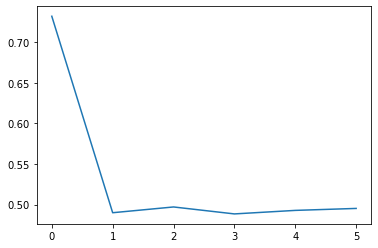

In [20]:
plt.plot(all_all_MAE[0])